# Курсовой проект для курса "Python для Data Science"


### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение моделей машинного обучения из библиотеки sklearn.

### Подключение библиотек и скриптов


In [138]:
import numpy as np
import pandas as pd
import random
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [139]:
import warnings
warnings.filterwarnings('ignore')

In [140]:
matplotlib.rcParams.update({'font.size': 14})

In [141]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
              
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к директориям и файлам


In [142]:
TRAIN_DATASET_PATH = 'C:/jn/project_task2/train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'C:/jn/project_task2/test.csv'
PREDICTIONS_DATASET_RATH = 'C:/jn/project_task2/ogrebennikova_predictions.csv'

#### Загрузка тренировочный данных  в переменную train_df 


In [143]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)


In [144]:
train_df.shape


(10000, 20)

In [145]:
train_df.head(5)## посмотрим на тренировочный датасет


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [146]:
train_df.tail(3) ###выведем последние 3 элемента, чтобы убедиться в количестве строк нашего сета, равного 10 000 строк

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


#### Загрузка тестовых данных  в переменную test_df

In [147]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [148]:
test_df.shape

(5000, 19)

In [149]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


### Описание дата сета
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры


### Начнем работу с данными тренировочного датасета

      * Когда мы импортировали данные и необходимые библиотеки выведем несколько записей из массива данных, посмотрим на некоторые статистические характеристики, типы данных, определим пропуски.

In [150]:
train_df.describe() ### применим эту функцию для получения некоторых статистические характеристики по столбцам 
              ###с числовыми значениями: среднее значение, среднее квадратическое отклонение, максимум, 
              ### минимум, квантили.. 
        

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [151]:
train_df.info() ### рассмотрим структуру нашего тренировочного датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [152]:
train_df.isnull().sum()### с помощью функции isnull() проверим количество пропущенных значений 


Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

  Наш тренировочный массив состоит из 10 000 записей, с типами данных: float64(8), int64(9), object(3), занимаемой памятью -1.5+ MB. В двух колонках 'LifeSquare'  и 'Healthcare_1' мы видим пропуски значений.

### Предварительная обработка данных
 Предже чем, передать набор данных на моделирование, нам необходимо очистить сет: обнаружить и исправить поврежденные или неточные записи, обработать пропуски, выбросы, дубликаты,заменить или удалить загрязненные данные.
 Необходимо это сделать не потеряв информацию. Для каждой обработки мы будет создавать свою переменную, не перезаписывая первоначального дата сета.

In [153]:
train_df.keys() ## выведем словать для удобной работы

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

 Поле id приведем к строчному типу,чтобы исключить его числовое влияние на анализ

In [154]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['Id'].dtype

dtype('O')

In [155]:
train_df['Healthcare_1'].head()


0       NaN
1     240.0
2     229.0
3    1084.0
4    2078.0
Name: Healthcare_1, dtype: float64

In [156]:
train_df['Healthcare_1'].median() ### посмотрим медианное значение этого параметра (частоту встречи)

900.0

 Приведем пропуски в колонке 'Healthcare_1' с помощью функции ' loc' к медиане значений этой колонки.

In [157]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

##### Посмотрим на выбросы в данных нашего сета


In [158]:
train_df['Rooms'].value_counts() # рассмотрим колонку 'Rooms'

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Отбросим явные выбросы 0, 10 и 19 с помощью функции loc

In [159]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

Посмотрим на выбросы по колонке 'Square' с помощью  графика

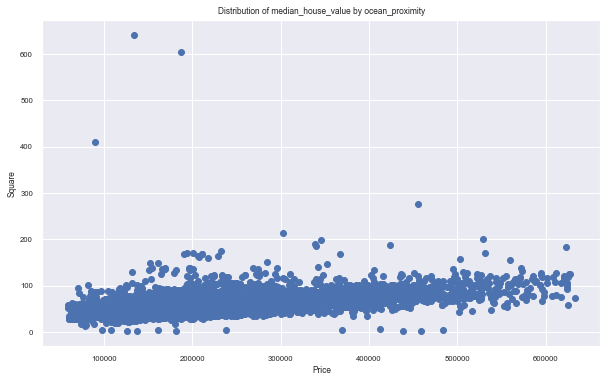

In [161]:
plt.figure(figsize=(10, 6))

plt.scatter(train_df['Price'], train_df['Square'])

plt.xlabel('Price')
plt.ylabel('Square')
plt.title('Distribution of median_house_value by ocean_proximity')
plt.show()

Мы видим значительные выбросы, по данных по'Square'. Кроме того, выбросы подтверждает и анализ статистических характеристик в разрезе квартилей по колонкам 'LifeSquare', 'KitchenSquare', которые мы сформированли с помощью функции .describe(). Мы отбрасывает все данные, входящие в 1% самых меньших данных и 1% -самых больших числовых данных, чтобы избавиться от явных выбросов

In [162]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [163]:
train_df.describe() # посмотрим на результат


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8881.000000,8881.000000,8881.000000,7296.000000,8881.000000,8881.000000,8881.000000,8.881000e+03,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000
mean,52.124536,1.884585,54.809487,34.830304,6.075329,8.446684,12.826934,4.242532e+03,0.119620,26.071163,5630.480014,8.403783,1038.373381,1.392636,4.438577,214939.479049
std,44.498118,0.797003,16.225349,14.280535,3.503611,5.133763,6.369206,2.127571e+05,0.119654,17.269698,3977.902810,24.295214,769.834857,1.492092,4.837340,89654.209673
min,0.000000,1.000000,29.719934,2.941437,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.637555,22.863805,1.000000,4.000000,9.000000,1.972000e+03,0.017647,10.000000,2370.000000,0.000000,810.000000,0.000000,1.000000,156934.440088
50%,40.000000,2.000000,51.656012,32.459931,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5562.000000,2.000000,900.000000,1.000000,3.000000,194240.534503
75%,80.000000,2.000000,64.720916,44.119769,9.000000,12.000000,17.000000,2.000000e+03,0.194489,36.000000,7614.000000,5.000000,1036.000000,3.000000,6.000000,250381.580780
max,209.000000,6.000000,117.855969,88.381356,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Воспользуемся функцией .mask() для замены значений 

In [164]:
mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,900.0,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,900.0,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,900.0,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


Отбросим величины 'LifeSquare' < 10  и 'KitchenSquare' < 3 как явные нереальные данные. Сделаем это с помощью функции loc

In [165]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [166]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

Рассмотрим 'HouseFloor','Floor'

In [167]:
train_df['HouseFloor'].sort_values().unique()# количество этажей в доме

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

In [168]:
train_df['Floor'].sort_values().unique() #этажи

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42],
      dtype=int64)

Количество этажей заменим на медиану 

In [169]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

Заполним случайными данными значения этажей из имеющихся допустимых

In [170]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Рассмотрим 'HouseYear'

In [171]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
2493        2020
9674        2020
4376        2020
          ...   
8144        1917
1380        1917
5053        1917
7611        1916
910         1914
Name: HouseYear, Length: 8881, dtype: int64

Можем заметить, участие числового показателя 20052011 года в постройке дома, что вызывает сильные сомнения, как и цифра 4968, заменяемм эти данные 

In [172]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

  Поработаем с пропуски в колонке 'LifeSquare' 

In [173]:
train_df['LifeSquare'].median() ### посмотрим медианное значение этого параметра

32.459930868446605

In [174]:
train_df['LifeSquare'].head()

0    29.442751
1    40.049543
3    52.731512
4    23.776169
5    46.683720
Name: LifeSquare, dtype: float64

Посмотрим на соотношение трех показателей площади , т.е 'Square', 'LifeSquare', 'KitchenSquare'

In [175]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
8,64.511437,NaN,3.0
9,46.461409,18.915552,8.0
10,46.304907,27.922584,6.0
11,68.808859,45.736906,7.0


In [176]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.490551802890103

In [177]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [178]:
train_df['LifeSquare'].median() #  смотрим как изменились медианные значения 

33.273699979715275

 Посмотрим на структуру колонок с типом object, на наличие пропусков, прочерков в данных

In [179]:
train_df['Shops_2'].value_counts()

B    8254
A     627
Name: Shops_2, dtype: int64

In [180]:
train_df['Ecology_3'].value_counts()


B    8614
A     267
Name: Ecology_3, dtype: int64

In [181]:
train_df['Ecology_2'].value_counts()

B    8792
A      89
Name: Ecology_2, dtype: int64

 Преобразуем категориальный признак  в  бинарный c помощью функции 'repiace' и создадим новые колонки данных

In [182]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

Посмотрим на наш тренировочный датасет после очитски данных

In [183]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8881 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8881 non-null   object 
 1   DistrictId     8881 non-null   int64  
 2   Rooms          8881 non-null   float64
 3   Square         8881 non-null   float64
 4   LifeSquare     8881 non-null   float64
 5   KitchenSquare  8881 non-null   float64
 6   Floor          8881 non-null   int64  
 7   HouseFloor     8881 non-null   float64
 8   HouseYear      8881 non-null   int64  
 9   Ecology_1      8881 non-null   float64
 10  Ecology_2      8881 non-null   object 
 11  Ecology_3      8881 non-null   object 
 12  Social_1       8881 non-null   int64  
 13  Social_2       8881 non-null   int64  
 14  Social_3       8881 non-null   int64  
 15  Healthcare_1   8881 non-null   float64
 16  Helthcare_2    8881 non-null   int64  
 17  Shops_1        8881 non-null   int64  
 18  Shops_2 

Мы видим, что нет пропусков, наши тренировочные данные содержат 8881 строку.

### Анализ целевой переменной - Price

In [184]:
train_df['Price'].value_counts()

207103.209097    1
303328.032075    1
174552.252385    1
456417.428803    1
149480.126085    1
                ..
115127.969838    1
222233.618608    1
464543.480148    1
376324.202739    1
151461.942091    1
Name: Price, Length: 8881, dtype: int64

#### Построим корреляционную матрицу зависимостей

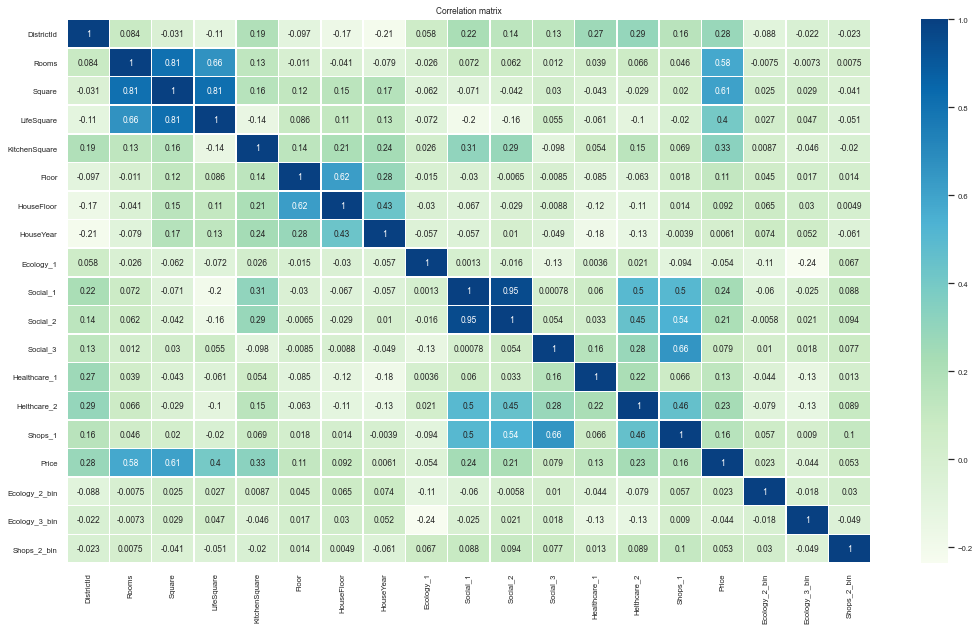

In [185]:
plt.figure(figsize = (18,10))

sns.set(font_scale=0.7)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Из данных матрицы мы видим, что интересуюшая нас переменная Price коррелирует больше всего с Rooms и Square

Построим график распределения

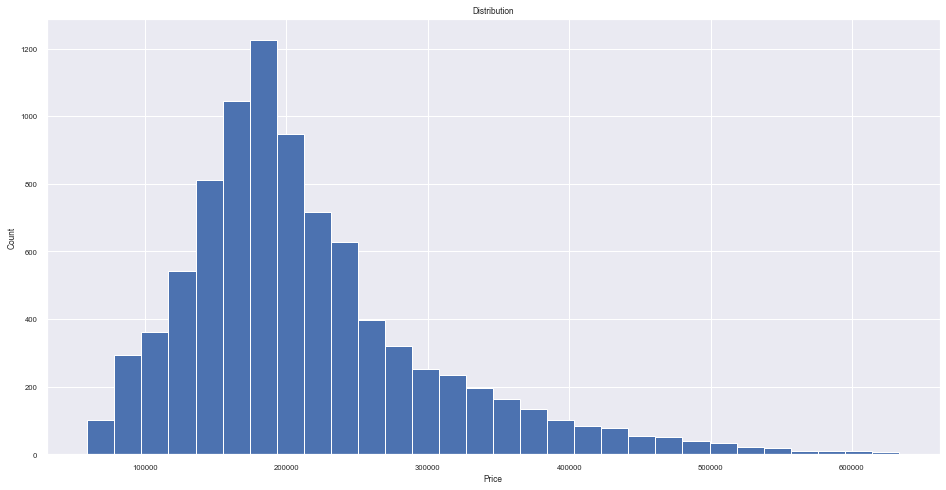

In [186]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Distribution')
plt.show()

Из данный графика мы видим, что данные ровные, выбросы отсутствуют. Далее расмотрим значение средней, медианы и моды нашей целевой переменной Price

In [187]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0] #наиболее популярное значение 

print("Среднее: ",target_mean)
print("Mедиана: ", target_median)
print("Мода: ", target_mode)


Среднее:  214939.48
Mедиана:  194240.53450304602
Мода:  59174.77802758122


Предствим статистические данные в графическом виде, чтобы увидеть более наглядно распредение данных. Посторим гистрограмму для численных значеий

In [188]:
df_num_features = train_df.select_dtypes(include='float64')

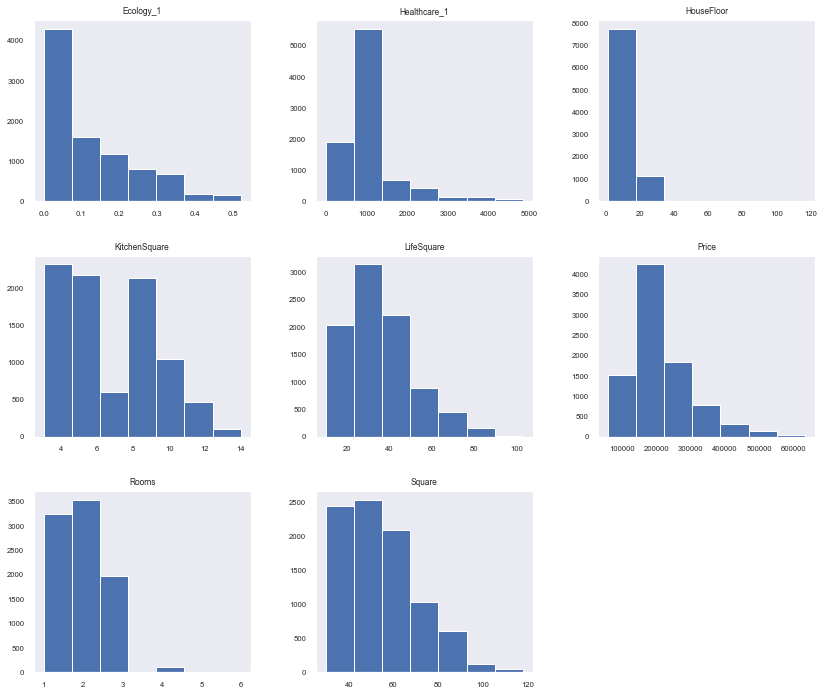

In [189]:
df_num_features.hist(figsize=(14,12), bins=7, grid=False);

Из данных графиков мы видим явную зависимость  параметров: Square, LifeSquare

Построим график зависимости цены от площади с помощью jointplot

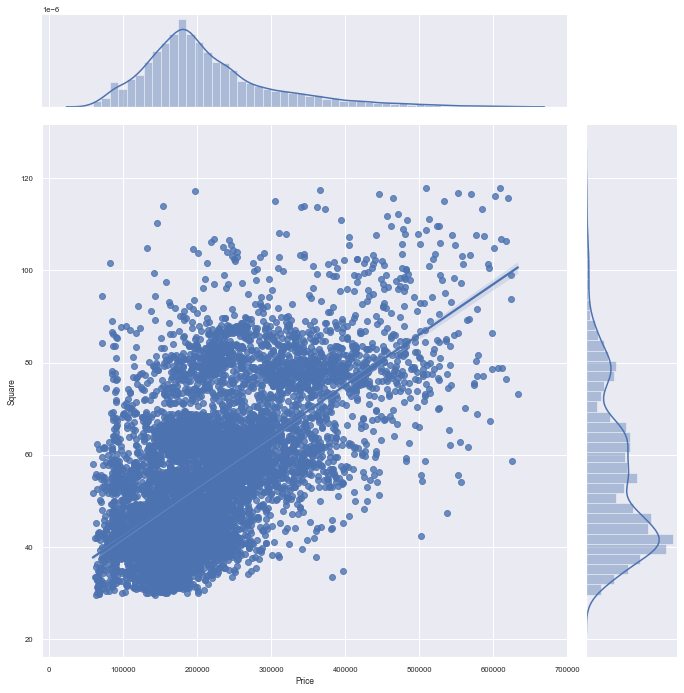

In [190]:
grid = sns.jointplot(train_df['Price'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(10)

plt.show()

Стоимость квартир увеличивается от увеличения площади, однако количество таких квартир уменьшается

In [191]:
train_df['Price'].value_counts()

207103.209097    1
303328.032075    1
174552.252385    1
456417.428803    1
149480.126085    1
                ..
115127.969838    1
222233.618608    1
464543.480148    1
376324.202739    1
151461.942091    1
Name: Price, Length: 8881, dtype: int64

In [192]:
train_df_s = train_df.select_dtypes(include=['float64', 'int64'])
train_df_s.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,900.0,0,11,184966.930730,1,1,1
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217,1,1,1
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644,1,1,1
5,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,35,7715,4,990.0,0,6,215898.447742,1,1,1


In [193]:
df_num_features = train_df.select_dtypes(include = ['object'])
df_num_features.head()

,Id,Ecology_2,Ecology_3,Shops_2
0,14038,B,B,B
1,15053,B,B,B
3,5809,B,B,B
4,10783,B,B,B
5,12915,B,B,B


Соединим данные Ecology_2 и Ecology_3 в "Eco2_Eco3", сгруппировав данные по Floor и Rooms, чтобы оптимизировать наши данные, уменьшить типичную и подозрительную  выборку

In [194]:
train_df["Eco2_Eco3"] = train_df.Ecology_2 + train_df.Ecology_3
train_df.groupby(["Floor"])["Rooms"].mean()

Floor
1     1.814324
2     1.934609
3     1.902746
4     1.941781
5     1.882283
6     1.882943
7     1.952303
8     1.882255
9     1.912548
10    1.814404
11    1.807018
12    1.776923
13    1.843750
14    1.900000
15    1.889908
16    1.859649
17    1.919355
18    1.944444
19    1.803922
20    1.833333
21    1.815789
22    2.194444
23    1.941176
24    1.760000
25    2.166667
28    1.500000
31    1.000000
32    1.000000
33    1.000000
42    2.000000
Name: Rooms, dtype: float64

Посмотрим на данные нашего тренировочного сета перед отбором данных

In [195]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8881 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8881 non-null   object 
 1   DistrictId     8881 non-null   int64  
 2   Rooms          8881 non-null   float64
 3   Square         8881 non-null   float64
 4   LifeSquare     8881 non-null   float64
 5   KitchenSquare  8881 non-null   float64
 6   Floor          8881 non-null   int64  
 7   HouseFloor     8881 non-null   float64
 8   HouseYear      8881 non-null   int64  
 9   Ecology_1      8881 non-null   float64
 10  Ecology_2      8881 non-null   object 
 11  Ecology_3      8881 non-null   object 
 12  Social_1       8881 non-null   int64  
 13  Social_2       8881 non-null   int64  
 14  Social_3       8881 non-null   int64  
 15  Healthcare_1   8881 non-null   float64
 16  Helthcare_2    8881 non-null   int64  
 17  Shops_1        8881 non-null   int64  
 18  Shops_2 

Составим тепловую карту для наших данных

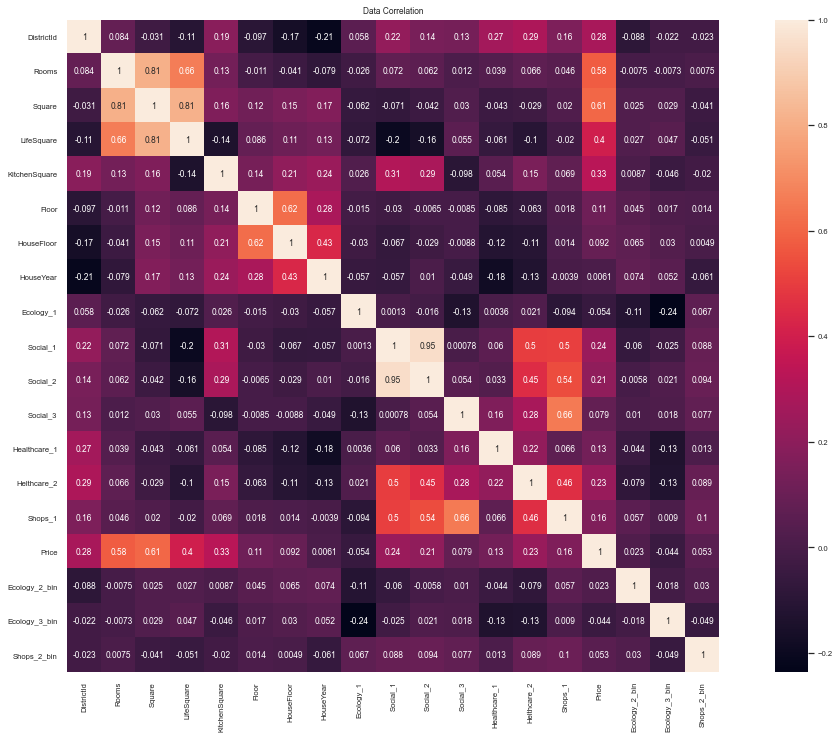

In [196]:
corrmat = train_df.loc[:,train_df.columns !='Id'].corr()
plt.figure(figsize=(20,12))
plt.title('Data Correlation')
sns.heatmap(corrmat,vmax=1.0, square=True, annot=True)

#### Теперь очистим тестовые данные для того, чтобы сделать предсказание. Проделаем с ними те же самые манипуляции, как и с обучающими данными

In [197]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['Id'].dtype

dtype('O')

In [198]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [199]:
test_df['Rooms'].value_counts() # рассмотрим колонку 'Rooms'

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [200]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = test_df['Rooms'].median()

In [201]:
test_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.00000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,51.279200,1.90780,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,44.179466,0.81008,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,0.000000,1.00000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.00000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,37.000000,2.00000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.00000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,212.000000,6.00000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [202]:
test_df.isnull().sum()### с помощью функции isnull() проверим количество пропущенных значений 

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [203]:
mask = test_df["Square"] < test_df["KitchenSquare"] + test_df["LifeSquare"]
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,900.0,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,900.0,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,900.0,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,900.0,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,900.0,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A


In [204]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [205]:
floor_outliers_test = test_df[test_df['Floor'] > test_df['HouseFloor']].index

test_df.loc[floor_outliers_test, 'Floor'] = test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [206]:
test_df['HouseYear'].sort_values(ascending=False)

4389    2020
4273    2020
888     2020
3255    2020
1039    2020
        ... 
1475    1912
64      1911
2691    1910
2       1909
3253    1908
Name: HouseYear, Length: 5000, dtype: int64

In [207]:
test_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,49.882643,33.432782,6.0
1,69.263183,NaN,1.0
2,13.597819,15.948246,12.0
3,73.046609,51.940842,9.0
4,47.527111,43.387569,1.0
5,40.675627,NaN,1.0
6,68.099538,64.843025,1.0
7,48.193897,32.857644,6.0
8,72.277106,45.968758,9.0
9,80.219400,47.660260,9.0


In [208]:
square_med_diff_test = (test_df.loc[test_df['LifeSquare'].notnull(), 'Square'] -\
                       test_df.loc[test_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                       test_df.loc[test_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff_test

11.38738439736359

In [209]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] =\
test_df.loc[test_df['LifeSquare'].isnull(), 'Square'] -\
test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff_test

In [210]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [211]:
test_df["Eco2_Eco3"] = test_df.Ecology_2 + test_df.Ecology_3
test_df.groupby(["Floor"])["Rooms"].mean()

Floor
1     1.888078
2     1.975385
3     1.857788
4     1.955056
5     1.972921
6     1.953623
7     1.840979
8     1.919643
9     1.947712
10    1.879464
11    1.829670
12    1.943128
13    1.965278
14    1.875817
15    1.688000
16    1.942149
17    1.835294
18    1.897436
19    1.692308
20    1.741935
21    1.692308
22    1.818182
23    1.850000
24    2.090909
25    1.785714
26    2.000000
28    2.000000
31    2.000000
32    2.000000
33    2.000000
34    2.000000
38    2.000000
46    2.000000
Name: Rooms, dtype: float64

In [212]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [213]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Отбор признаков тренировочного файла

In [214]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'Eco2_Eco3']

Отберем числовые значение наиболее коррелирующие с целевой переменной Price

In [215]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

target_name = 'Price'

In [216]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8881 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8881 non-null   object 
 1   DistrictId     8881 non-null   int64  
 2   Rooms          8881 non-null   float64
 3   Square         8881 non-null   float64
 4   LifeSquare     8881 non-null   float64
 5   KitchenSquare  8881 non-null   float64
 6   Floor          8881 non-null   int64  
 7   HouseFloor     8881 non-null   float64
 8   HouseYear      8881 non-null   int64  
 9   Ecology_1      8881 non-null   float64
 10  Ecology_2      8881 non-null   object 
 11  Ecology_3      8881 non-null   object 
 12  Social_1       8881 non-null   int64  
 13  Social_2       8881 non-null   int64  
 14  Social_3       8881 non-null   int64  
 15  Healthcare_1   8881 non-null   float64
 16  Helthcare_2    8881 non-null   int64  
 17  Shops_1        8881 non-null   int64  
 18  Shops_2 

In [242]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [217]:
train_df.shape

(8881, 24)

In [342]:
test_df.shape

(5000, 23)

#### Разбиение на  train и test с помощью функции train_test_split, при этом размер тестовой выборки равен 33% от всех данных

In [219]:
##train_df["Rooms_vc"] = train_df["Rooms"].map(train_df["Rooms"].value_counts().to_dict())

In [343]:
X = train_df[feature_names]
y = train_df[target_name]
##X = test_df[feature_names]

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [345]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8881 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          8881 non-null   float64
 1   Square         8881 non-null   float64
 2   LifeSquare     8881 non-null   float64
 3   KitchenSquare  8881 non-null   float64
 4   Floor          8881 non-null   int64  
 5   HouseFloor     8881 non-null   float64
 6   HouseYear      8881 non-null   int64  
 7   Ecology_1      8881 non-null   float64
 8   Ecology_2_bin  8881 non-null   int64  
 9   Ecology_3_bin  8881 non-null   int64  
 10  Social_1       8881 non-null   int64  
 11  Social_2       8881 non-null   int64  
 12  Social_3       8881 non-null   int64  
 13  Healthcare_1   8881 non-null   float64
 14  Helthcare_2    8881 non-null   int64  
 15  Shops_1        8881 non-null   int64  
 16  Shops_2_bin    8881 non-null   int64  
dtypes: float64(7), int64(10)
memory usage: 1.5 MB


In [346]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 8793 to 8567
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          2665 non-null   float64
 1   Square         2665 non-null   float64
 2   LifeSquare     2665 non-null   float64
 3   KitchenSquare  2665 non-null   float64
 4   Floor          2665 non-null   int64  
 5   HouseFloor     2665 non-null   float64
 6   HouseYear      2665 non-null   int64  
 7   Ecology_1      2665 non-null   float64
 8   Ecology_2_bin  2665 non-null   int64  
 9   Ecology_3_bin  2665 non-null   int64  
 10  Social_1       2665 non-null   int64  
 11  Social_2       2665 non-null   int64  
 12  Social_3       2665 non-null   int64  
 13  Healthcare_1   2665 non-null   float64
 14  Helthcare_2    2665 non-null   int64  
 15  Shops_1        2665 non-null   int64  
 16  Shops_2_bin    2665 non-null   int64  
dtypes: float64(7), int64(10)
memory usage: 374.8 KB


### Построение модели

#### Обучение модели

In [287]:
X_train.isnull().sum() # проверим нет ли пропусков

Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2_bin    0
Ecology_3_bin    0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2_bin      0
dtype: int64

### Случайный лес

В этом алгоритме используется ансамбль деревьев решений. Для каждого обучаемого дерева решений создаётся подвыборка из исходной тренировочной выборки, кроме того, при обучении каждого дерева используется лишь часть признаков. 
На этапе предсказания мы учитываем ответы, полученные каждым из деревьев, и выбираем тот ответ, за который "проголосовало" наибольшее количество деревьев. Это позволяет, в частности, уменьшить влияние переобучения каждого из деревьев.

In [288]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

#### Отложенная выборка

Train R2:	0.96
Test R2:	0.96


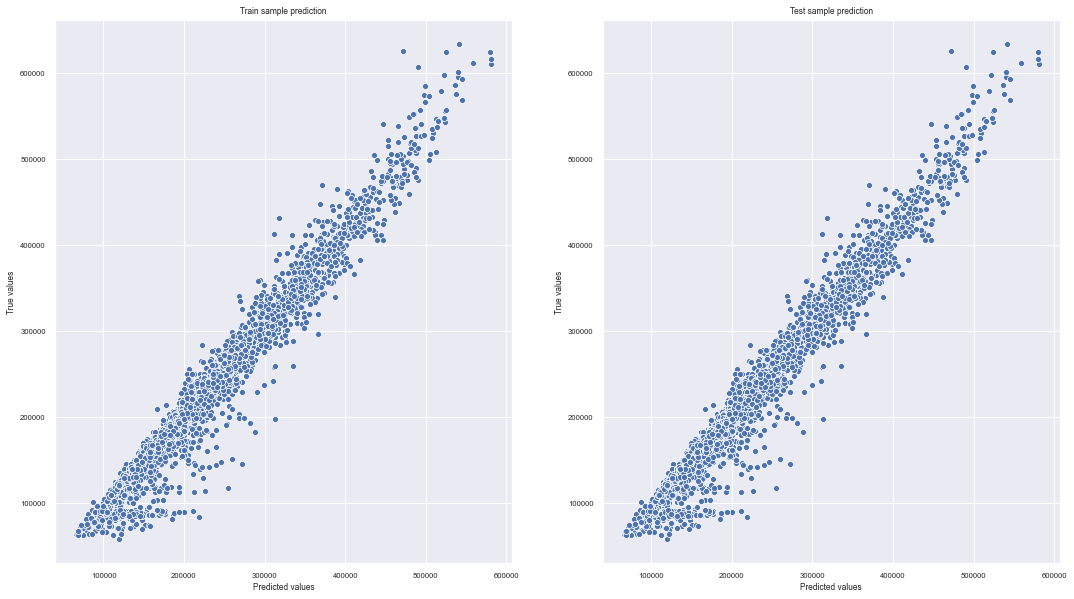

In [289]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds, y_train, y_train_preds)

Mы сравнили тренировочную модель с фактичекой. 

Теперь сравним тренировочный тест c тестовым

Train R2:	0.96
Test R2:	0.693


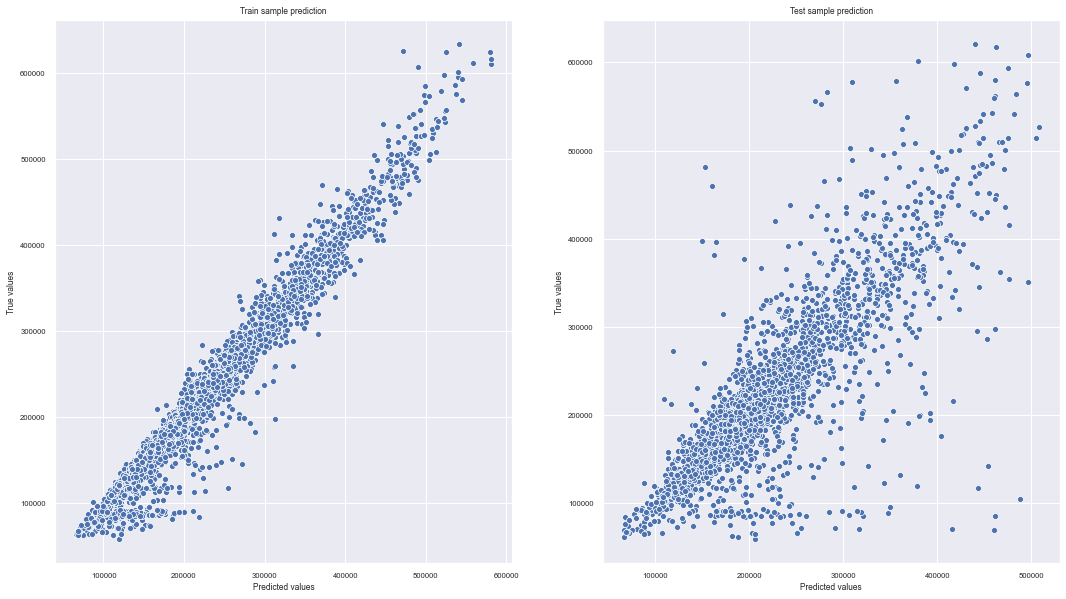

In [290]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Модель линейной регрессии 'Linear Regression' предсказывает значение целевой переменной. Чтобы обучить модель, мы используем метод .fit, в который передаём нашу тренировочную выборку

In [291]:
from sklearn.linear_model import LinearRegression

In [292]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [293]:
y_train_preds = lr_model.predict(X_train)

Теперь, когда модель обучена, мы можем получить предсказанные значения на объектах X_test с помощью метода .predict. Сравним данные обучения сетов 

Train R2:	0.524
Test R2:	0.522


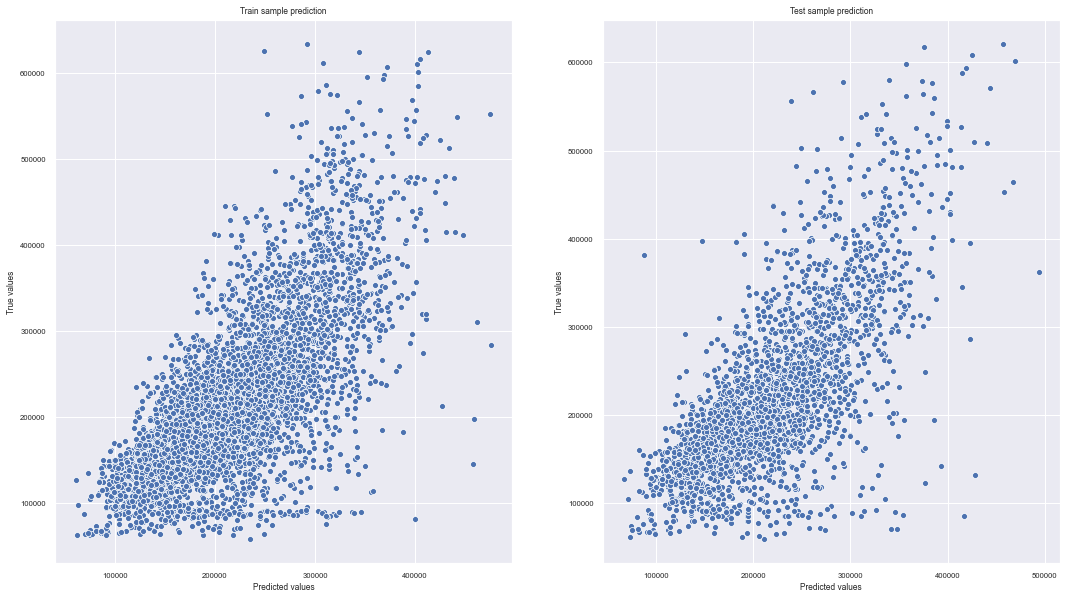

In [294]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_train, y_train_preds,y_test, y_test_preds)

Очень слабые данные, мы видим что показатель R2 < 0.6

#### Используем GradientBoostingRegressor

In [295]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [296]:
y_train_preds = gb_model.predict(X_train)


Train R2:	0.756
Test R2:	0.694


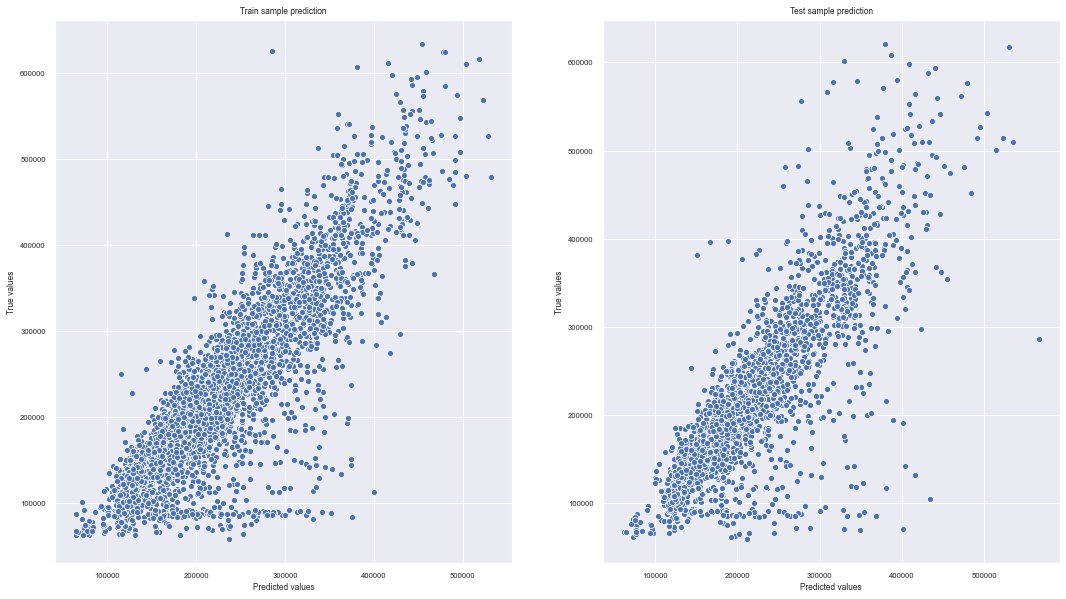

In [297]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_train, y_train_preds,y_test, y_test_preds)

#### Настройка и оценка финальной модели

In [298]:
0.6*X_train.shape[1]

10.2

In [299]:
gb_model = GradientBoostingRegressor(random_state=21)
gb_model

GradientBoostingRegressor(random_state=21)

In [300]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=21), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [301]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [302]:
gs.best_score_

0.7217988935737069

**Обучение и оценка модели**

In [308]:
final_model = GradientBoostingRegressor(n_estimators=400, max_depth=7, random_state=42)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=7, n_estimators=400, random_state=42)

In [309]:
y_train_preds = final_model.predict(X_train)

In [310]:
y_test_preds = final_model.predict(X_test)


Train R2:	0.991
Test R2:	0.707


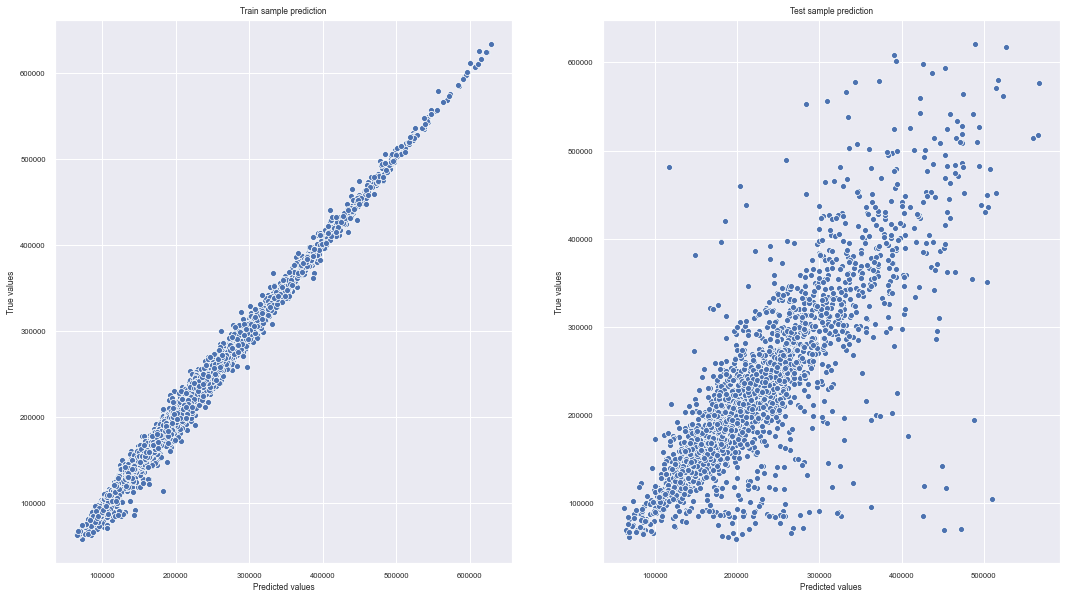

In [311]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Важность признаков

In [312]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.395957
11,Social_2,0.118504
10,Social_1,0.081582
0,Rooms,0.061158
12,Social_3,0.060959
6,HouseYear,0.050980
7,Ecology_1,0.047797
2,LifeSquare,0.045292
13,Healthcare_1,0.028475
3,KitchenSquare,0.027654


Мы видим, что важным признаком является площать - Square. Вторым показателем является социальные показатели местности Social_2

#### Перекрестная проверка

Кросс-валидация или скользящий контроль. С помощью кросс-валидации эмулируется наличие тестовой выборки, которая не учавствует в обучении, но для которой известны правильные ответы

In [313]:
cv_score = cross_val_score(rf_model, X.fillna(-9999), y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.69625581, 0.67834449, 0.71675929, 0.73473009, 0.73204102])

In [314]:
cv_score.mean(), cv_score.std()

(0.7116261403172939, 0.0215444863551297)

In [315]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.6900816539621641, 0.7331706266724236)

In [317]:
y_test_preds

array([150949.6970645 , 300385.90861173, 133324.61371448, ...,
       235847.25037829, 230036.69492847, 303420.52583816])

In [352]:
pred_final = pd.DataFrame(y_test_preds)
pred_final

,0
0,150949.697064
1,300385.908612
2,133324.613714
3,311156.230583
4,181356.361081
...,...
2926,109848.856440
2927,347537.907272
2928,235847.250378
2929,230036.694928


 Лучшая модель, согласно анализа наших графиков сравнений это модель с показателем Test R2:	0.682 - final_model, полученная с помощью GradientBoostingRegressor.

Сохранение модели

In [353]:
test_f = list(X_train.columns)

In [354]:
test_df[test_f].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   float64
 1   Square         5000 non-null   float64
 2   LifeSquare     5000 non-null   float64
 3   KitchenSquare  5000 non-null   float64
 4   Floor          5000 non-null   int64  
 5   HouseFloor     5000 non-null   float64
 6   HouseYear      5000 non-null   int64  
 7   Ecology_1      5000 non-null   float64
 8   Ecology_2_bin  5000 non-null   int64  
 9   Ecology_3_bin  5000 non-null   int64  
 10  Social_1       5000 non-null   int64  
 11  Social_2       5000 non-null   int64  
 12  Social_3       5000 non-null   int64  
 13  Healthcare_1   5000 non-null   float64
 14  Helthcare_2    5000 non-null   int64  
 15  Shops_1        5000 non-null   int64  
 16  Shops_2_bin    5000 non-null   int64  
dtypes: float64(7), int64(10)
memory usage: 664.2 KB


In [355]:
test_df['Price'] = final_model.predict(test_df[test_f])

In [356]:
test_df[['Id','Price']].to_csv(PREDICTIONS_DATASET_RATH,index=False)

The end